In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [ ]:
import importlib

for module in ['kooplearn', 'datasets', 'matplotlib', 'ml-confs']: # !! Add here any additional module that you need to install on top of kooplearn
    try:
        importlib.import_module(module)
    except ImportError:
        if module == 'kooplearn':
            module = 'kooplearn[full]'
        %pip install  -q {module}


: 

In [ ]:
import matplotlib.pyplot as plt
import torch
import json
from typing import NamedTuple, Tuple
import numpy as np
from datetime import datetime
from tqdm import tqdm
import pickle

from  src import OU_process
from tqdm import tqdm
import ml_confs
from pathlib import Path
from kooplearn.models import Linear, Nonlinear, Kernel
from kooplearn.models.feature_maps.nn import NNFeatureMap
from kooplearn.data import traj_to_contexts
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import  ParameterGrid
import time
CV = True

: 

In [4]:
# # tsCV = TimeSeriesSplit(n_splits=2, max_train_size= configs.n_train_points)
# tikhonov_regs = np.geomspace(1e-8, 1e-1, 20)
# length_scales = np.geomspace(1e-8, 1e3, 20)
# params = list(
#     ParameterGrid(
#         { 
#             'tikhonov_reg': tikhonov_regs, 
#             'length_scale': length_scales,
#         }
#     )
# )
# backend = 'cpu'

In [5]:
# if CV:
#     error = np.empty((len(params), 2))
#     for iter_idx, iterate in tqdm(enumerate(params), total=len(params)):      
#         _err = []
#         for i in range(configs.n_repits):
#             train_data = traj_to_contexts(data_points[0:configs.n_train_points][:,i], backend='numpy')
#             val_data = traj_to_contexts(data_points[configs.n_train_points: configs.n_train_points + configs.n_val_points][:,i], backend='numpy')
#             # test_data = traj_to_contexts(data_points[configs.n_train_points + configs.n_val_points:][:,i], backend='numpy')
#             model = Kernel(RBF(length_scale= 0.5), reduced_rank=True, rank = configs.rank, tikhonov_reg = 1e-4).fit(train_data)
#             _err.append(model.risk(val_data))

#         _err = np.array(_err)
#         error[iter_idx, 0] = np.mean(_err)
#         error[iter_idx, 1] = np.std(_err)

In [6]:
# if CV:
#     fig, ax = plt.subplots()     
#     mean = error[:,0]
#     std = error[:,1]
#     ax.fill_between(coef0, mean - std, mean + std, alpha = 0.5)
#     ax.plot(coef0, mean, '.-')
#     ax.margins(0)
#     ax.set_ylabel("Test error")
#     ax.set_xscale('log')
#     ax.set_yscale('log')

In [7]:
# def biased_covariance_estimator(cov_mtx, tau):
#     block_cov_matrix = make_block_matrices(cov_mtx,tau)
#     diag_blocks = torch.diagonal(torch.from_numpy(block_cov_matrix), offset=0, dim1=0, dim2=1)
#     return torch.sum(torch.pow(diag_blocks,2))

# def unbiased_covariance_estimator(cov_mtx, tau):
#     n = cov_mtx.shape[0]
#     block_cov_matrix = make_block_matrices(cov_mtx,tau)
#     block_cov_matrix = torch.from_numpy(block_cov_matrix)

#     diag_blocks = torch.diagonal(block_cov_matrix, offset=0, dim1=0, dim2=1)
#     plus_term = torch.sum(torch.pow(diag_blocks,2))
#     minus_term = 0
#     for signed in [1,-1]:
#         for i in range(2,n, 2):
#             diag_blocks = torch.diagonal(block_cov_matrix, offset=i*signed, dim1=0, dim2=1)
#             minus_term += torch.sum(torch.pow(diag_blocks,2)) 
    
#     # print(plus_term, minus_term)
#     sum = plus_term - (minus_term / ((n/(2*tau))-1))
#     if sum < 0:
#         sum = 0.0

#     return sum

In [8]:
def make_block_matrices(matrix, tau):
    n = matrix.shape[0]
    assert n % tau == 0, "Matrix dimensions must be divisible by tau"

    n_blocks = n // tau
    blocks = matrix.reshape(n_blocks, tau, n_blocks, tau)
    block_matrix_result = blocks.transpose(0, 2, 1, 3)
    
    return block_matrix_result

def biased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    block_cov_matrix = make_block_matrices(cov_mtx,tau) /np.sqrt(n*tau)
    diag_blocks = torch.diagonal(torch.from_numpy(block_cov_matrix), offset=0, dim1=0, dim2=1)
    return torch.sum(torch.pow(diag_blocks,2))

def unbiased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    m = n / (2*tau)
    block_cov_matrix = make_block_matrices(cov_mtx,tau)/np.sqrt(n*tau)
    block_cov_matrix = torch.from_numpy(block_cov_matrix)

    diag_blocks = torch.diagonal(block_cov_matrix, offset=0, dim1=0, dim2=1)
    sum = torch.sum(torch.pow(diag_blocks,2))
    for signed in [1,-1]:
        for i in range(2,n, 2):
            diag_blocks = torch.diagonal(block_cov_matrix, offset=i*signed, dim1=0, dim2=1)
            sum -= torch.sum(torch.pow(diag_blocks,2)) / (m-1)
    
    # print(plus_term, minus_term)
    if sum < 0:
        sum = 0.0

    return sum 

In [9]:
# a = np.random.randint(0,3,(8,8)) * 1.0
# a 

In [10]:
# biased_covariance_estimator(a, tau= 2)

In [11]:
# unbiased_covariance_estimator(a, tau= 2)

In [12]:
# c_h = 1
# for i in range(configs.n_repits):    
#     X = data_points[0:][:,i]
#     X = X.reshape(X.shape[0], -1)
#     kernel_matrix = gauss_kernel(X, X)
#     if np.max(kernel_matrix) > c_h:
#         c_h = np.max(kernel_matrix)
#     print(c_h)


In [9]:
import collections
import itertools


def prime_factors(n):
    i = 2
    while i * i <= n:
        if n % i == 0:
            n /= i
            yield i
        else:
            i += 1

    if n > 1:
        yield n


def prod(iterable):
    result = 1
    for i in iterable:
        result *= i
    return result


def get_divisors(n):
    pf = prime_factors(n)

    pf_with_multiplicity = collections.Counter(pf)

    powers = [
        [factor ** i for i in range(count + 1)]
        for factor, count in pf_with_multiplicity.items()
    ]

    for prime_power_combo in itertools.product(*powers):
        yield prod(prime_power_combo)

In [63]:
def Covariance_Estimation(data_points, n, delta, length_scale):
    for tau in range(1,n):
        if delta >= 2*(n/(2*tau) - 1)*np.exp(-(np.exp(1) -  1)/np.exp(1)*tau) and (n / tau) % 2 == 0 :
            min_tau = tau
            break
    
    gauss_kernel = RBF(length_scale=length_scale)
    c_h = 1
    L = 2 * c_h
    sigma = c_h
    divisors = np.array(list(get_divisors(n)))
    divisors = list(np.sort(divisors[divisors > min_tau]))
    taus = [divisor for divisor in divisors if (n / divisor) % 2 == 0 ]
    n_0 = len(taus)
    data_bound_biased_cov_est = np.empty((n_0, configs.n_repits))
    data_bound_unbiased_cov_est = np.empty((n_0, configs.n_repits))
    pess_bound = np.empty((n_0, configs.n_repits))

    for i in tqdm(range(configs.n_repits)):    
        X = data_points[0:n][:,i]
        X = X.reshape(X.shape[0], -1)
        kernel_matrix = gauss_kernel(X, X)
        # print(kernel_matrix) 
        for j in range(n_0):
            tau = taus[j]
            beta_coeff = np.exp((1/np.exp(1) - 1) *tau)
            m = n / (2*tau)
            # print(delta - 2*(m-1)*beta_coeff)

            l_tau = np.log(4/(delta - 2*(m-1)*beta_coeff))
            
            pess_bound[j][i] = (((2 * L ) / m)  + (2 * sigma)/np.sqrt(m))* l_tau
            
            cov_biased = biased_covariance_estimator(kernel_matrix, tau= tau)
            data_bound_biased_cov_est[j][i] = ((16*c_h)/(3*m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_biased)/m)
            
            cov_unbiased = unbiased_covariance_estimator(kernel_matrix, tau= tau)
            # print(cov_biased, cov_unbiased)
            data_bound_unbiased_cov_est[j][i] = ((13*c_h)/(m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_unbiased)/m)
            # biased_bounds.append(biased_covariance_estimator(kernel_matrix, tau= tau))
            # unbiased_bounds.append(unbiased_covariance_estimator(kernel_matrix, tau= tau))
    
    return pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus

In [15]:
# def plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale):
#     pess_bound_mean = np.mean(pess_bound, axis=-1)
#     pess_bound_std = np.std(pess_bound, axis=-1)

#     data_bound_biased_est_mean = np.mean(data_bound_biased_cov_est, axis=-1)
#     data_bound_biased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

#     data_bound_unbiased_est_mean = np.mean(data_bound_unbiased_cov_est, axis=-1)
#     data_bound_unbiased_est_std = np.std(data_bound_unbiased_cov_est, axis=-1)

#     # Plot with larger figure size and font sizes
#     plt.figure(figsize=(12, 8))  # Adjust figure size as needed

#     plt.loglog(taus, data_bound_unbiased_est_mean, marker='o', label="Emp. bound (unbiased cov. est.)", linewidth=2)
#     plt.fill_between(taus, data_bound_unbiased_est_mean - data_bound_unbiased_est_std, 
#                      data_bound_unbiased_est_mean + data_bound_unbiased_est_std, alpha=0.2)

#     plt.loglog(taus, data_bound_biased_est_mean, marker='s', label="Emp. bound (biased cov. est.)", linewidth=2)
#     plt.fill_between(taus, data_bound_biased_est_mean - data_bound_biased_est_std, 
#                      data_bound_biased_est_mean + data_bound_biased_est_std, alpha=0.2)

#     plt.loglog(taus, pess_bound_mean, marker='^', label="Pessimistic bound", linewidth=2)
#     plt.fill_between(taus, pess_bound_mean - pess_bound_std, 
#                      pess_bound_mean + pess_bound_std, alpha=0.2)

#     plt.xlabel("Block size", fontsize=18)
#     plt.ylabel("Covariance upper bound", fontsize=18)
#     # plt.title(f"Covariance Upper Bounds (delta = {delta}) of OU Process ({n} train samples) with Gaussian Kernel (l={length_scale})", fontsize=16)

#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.legend(fontsize=16)
#     plt.grid(True)
    
#     plt.savefig(f"OU_Exp_tau_n_{n}_delta_{delta}_l_{length_scale}.pdf", format="pdf", dpi=300)
#     plt.show()


In [61]:
configs = ml_confs.from_file('configs.yaml') # Load configs
data_points = OU_process.sample(configs.n_train_points + configs.n_val_points + configs.n_test_points, num_trajectories= configs.n_repits)
data_points.shape

(40000, 30)

In [60]:
def plot_OU_tau(ax, pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale, show_ylabel=False):
    pess_bound_mean = np.mean(pess_bound, axis=-1)
    pess_bound_std = np.std(pess_bound, axis=-1)

    data_bound_biased_est_mean = np.mean(data_bound_biased_cov_est, axis=-1)
    data_bound_biased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

    data_bound_unbiased_est_mean = np.mean(data_bound_unbiased_cov_est, axis=-1)
    data_bound_unbiased_est_std = np.std(data_bound_unbiased_cov_est, axis=-1)

    # Plot with appropriate figure size and font sizes
    line1, = ax.loglog(taus, data_bound_unbiased_est_mean, marker='o', label="Emp. bound (unbiased cov. est.)", linewidth=1)
    ax.fill_between(taus, data_bound_unbiased_est_mean - data_bound_unbiased_est_std, 
                    data_bound_unbiased_est_mean + data_bound_unbiased_est_std, alpha=0.2)

    line2, = ax.loglog(taus, data_bound_biased_est_mean, marker='s', label="Emp. bound (biased cov. est.)", linewidth=1)
    ax.fill_between(taus, data_bound_biased_est_mean - data_bound_biased_est_std, 
                    data_bound_biased_est_mean + data_bound_biased_est_std, alpha=0.2)

    line3, = ax.loglog(taus, pess_bound_mean, marker='^', label="Pessimistic bound", linewidth=1)
    ax.fill_between(taus, pess_bound_mean - pess_bound_std, 
                    pess_bound_mean + pess_bound_std, alpha=0.2)

    ax.set_xlabel("Block size", fontsize=10)
    if show_ylabel:
        ax.set_ylabel("Covariance upper bound", fontsize=10)
    ax.set_title(f"length scale ={length_scale}", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)
    
    return line1, line2, line3

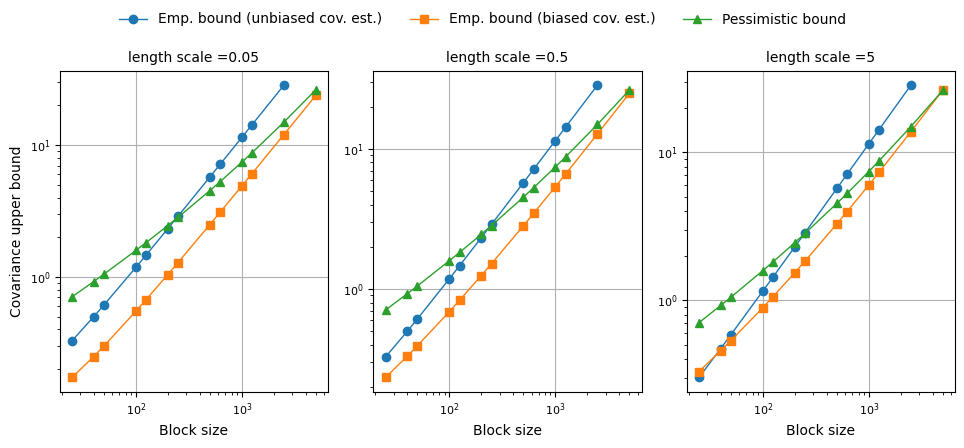

In [70]:
n = 10000
delta = 0.05
length_scales = [0.05, 0.5, 5]
pess_bounds = []
data_bounds_biased = []
data_bounds_unbiased = []
for l in length_scales:
    # pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, l)
    # np.save(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy', pess_bound)
    # np.save(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_biased_cov_est)
    # np.save(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_unbiased_cov_est)

    # pess_bounds.append(pess_bound) 
    # data_bounds_biased.append(data_bound_biased_cov_est)
    # data_bounds_unbiased.append(data_bound_unbiased_cov_est)

    pess_bounds.append(np.load(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy'))
    data_bounds_biased.append(np.load(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))
    data_bounds_unbiased.append(np.load(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))

# Create a figure with 3 subplots in a row, single-column width (3.25 inches)
fig, axes = plt.subplots(1, 3, figsize=(3.25 * 3, 4.5))  # Adjust height as needed for visibility

# Plot each subplot and collect lines for the legend
lines = []
for i, length_scale in enumerate(length_scales):
    show_ylabel = (i == 0)  # Only show y-axis label on the first subplot
    lines += plot_OU_tau(axes[i], pess_bounds[i], data_bounds_biased[i], data_bounds_unbiased[i], taus, n=n, delta=delta, length_scale=length_scale, show_ylabel=show_ylabel)

# Create a common legend
labels = ["Emp. bound (unbiased cov. est.)", "Emp. bound (biased cov. est.)", "Pessimistic bound"]
fig.legend(lines[:3], labels, loc='upper center', fontsize=10, ncol=3, frameon=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.85)  # Add more space between title and legend
plt.savefig(f"OU_Exp_tau_n_{n}_delta_{delta}.pdf", format="pdf", dpi=600)
plt.show()

100%|██████████| 30/30 [02:09<00:00,  4.33s/it]


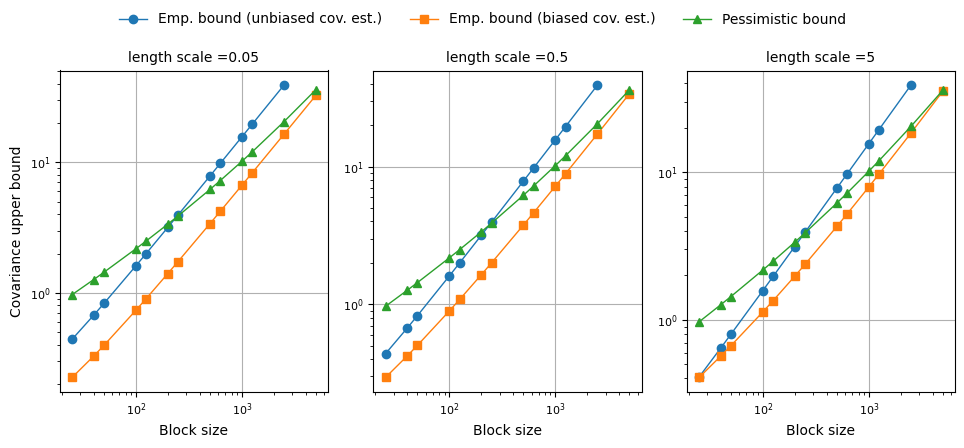

In [71]:
n = 10000
delta = 0.01
length_scales = [0.05, 0.5, 5]
pess_bounds = []
data_bounds_biased = []
data_bounds_unbiased = []
for l in length_scales:
    pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, l)
    np.save(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy', pess_bound)
    np.save(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_biased_cov_est)
    np.save(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_unbiased_cov_est)

    pess_bounds.append(pess_bound) 
    data_bounds_biased.append(data_bound_biased_cov_est)
    data_bounds_unbiased.append(data_bound_unbiased_cov_est)

    # pess_bounds.append(np.load(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy'))
    # data_bounds_biased.append(np.load(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))
    # data_bounds_unbiased.append(np.load(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))

# Create a figure with 3 subplots in a row, single-column width (3.25 inches)
fig, axes = plt.subplots(1, 3, figsize=(3.25 * 3, 4.5))  # Adjust height as needed for visibility

# Plot each subplot and collect lines for the legend
lines = []
for i, length_scale in enumerate(length_scales):
    show_ylabel = (i == 0)  # Only show y-axis label on the first subplot
    lines += plot_OU_tau(axes[i], pess_bounds[i], data_bounds_biased[i], data_bounds_unbiased[i], taus, n=n, delta=delta, length_scale=length_scale, show_ylabel=show_ylabel)

# Create a common legend
labels = ["Emp. bound (unbiased cov. est.)", "Emp. bound (biased cov. est.)", "Pessimistic bound"]
fig.legend(lines[:3], labels, loc='upper center', fontsize=10, ncol=3, frameon=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.85)  # Add more space between title and legend
plt.savefig(f"OU_Exp_tau_n_{n}_delta_{delta}.pdf", format="pdf", dpi=600)
plt.show()

100%|██████████| 30/30 [11:43<00:00, 23.46s/it]


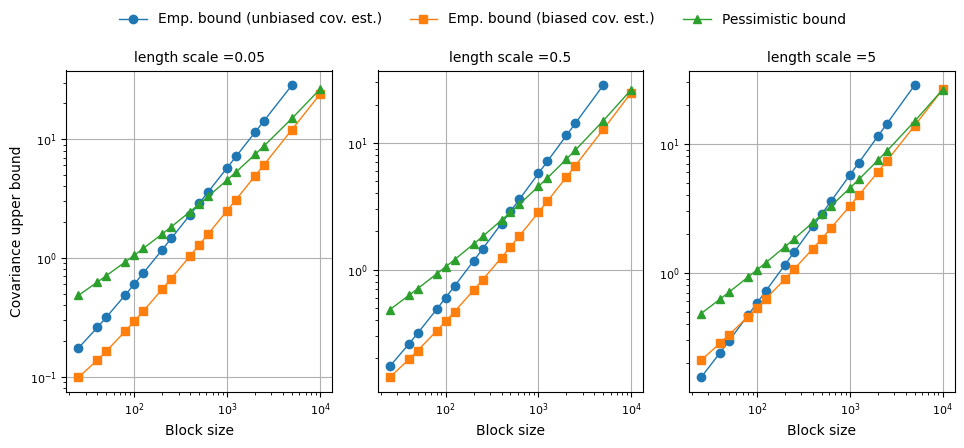

In [73]:
n = 20000
delta = 0.05
length_scales = [0.05, 0.5, 5]
pess_bounds = []
data_bounds_biased = []
data_bounds_unbiased = []
for l in length_scales:
    pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, l)
    np.save(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy', pess_bound)
    np.save(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_biased_cov_est)
    np.save(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy', data_bound_unbiased_cov_est)

    pess_bounds.append(pess_bound) 
    data_bounds_biased.append(data_bound_biased_cov_est)
    data_bounds_unbiased.append(data_bound_unbiased_cov_est)

    # pess_bounds.append(np.load(f'pess_bound_n_{n}_delta_{delta}_l_{l}.npy'))
    # data_bounds_biased.append(np.load(f'data_bound_biased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))
    # data_bounds_unbiased.append(np.load(f'data_bound_unbiased_cov_est_n_{n}_delta_{delta}_l_{l}.npy'))

# Create a figure with 3 subplots in a row, single-column width (3.25 inches)
fig, axes = plt.subplots(1, 3, figsize=(3.25 * 3, 4.5))  # Adjust height as needed for visibility

# Plot each subplot and collect lines for the legend
lines = []
for i, length_scale in enumerate(length_scales):
    show_ylabel = (i == 0)  # Only show y-axis label on the first subplot
    lines += plot_OU_tau(axes[i], pess_bounds[i], data_bounds_biased[i], data_bounds_unbiased[i], taus, n=n, delta=delta, length_scale=length_scale, show_ylabel=show_ylabel)

# Create a common legend
labels = ["Emp. bound (unbiased cov. est.)", "Emp. bound (biased cov. est.)", "Pessimistic bound"]
fig.legend(lines[:3], labels, loc='upper center', fontsize=10, ncol=3, frameon=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.85)  # Add more space between title and legend
plt.savefig(f"OU_Exp_tau_n_{n}_delta_{delta}.pdf", format="pdf", dpi=600)
plt.show()

In [ ]:
# n = 20000
# delta = 0.05
# length_scale= 5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 10000
# delta = 0.05
# length_scale= 0.5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 10000
# delta = 0.05
# length_scale= 0.05

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 10000
# delta = 0.01
# length_scale= 5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 10000
# delta = 0.01
# length_scale= 0.5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 10000
# delta = 0.01
# length_scale= 0.05

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 20000
# delta = 0.05
# length_scale= 5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 20000
# delta = 0.05
# length_scale= 0.5

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)

# n = 20000
# delta = 0.05
# length_scale= 0.05

# pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus = Covariance_Estimation(data_points, n, delta, length_scale)
# plot_OU_tau(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, taus, n, delta, length_scale)


In [28]:
# delta = 0.05
# length_scale= 0.5
# Ns = [100,200,500,1000,2000,5000,10000,20000,40000]

# n = Ns[5]
# gauss_kernel = RBF(length_scale=length_scale)

# X = data_points[0:n][:,1]
# X = X.reshape(X.shape[0], -1).astype('float16')
# print(X.shape)
# kernel_Matrix = gauss_kernel(X, X).astype('float16')
# print("SALAVAT")   

# trace_C2 = np.sqrt(1/(1+4/(length_scale*length_scale)))
# B = 10000
# T = 100
# data_points2 = OU_process.sample(B, num_trajectories= T).astype('float16') 

# trace_C_hat2 = np.linalg.norm(kernel_Matrix/(n))**2
# trace_C_C_hat = 0
# for t in tqdm(range(T)):
#     X_prime = data_points2[:,t]
#     X_prime = X_prime.reshape(X_prime.shape[0], -1) 
#     c = np.linalg.norm(gauss_kernel(X_prime,X)/(np.sqrt(B*n*T)))**2
#     # print(c, trace_C2, trace_C_hat2)
#     trace_C_C_hat += c

(5000, 1)
SALAVAT


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


In [29]:
# t

In [30]:
# trace_C2

0.24253562503633297

In [31]:
# trace_C_hat2

0.24488013052711555

In [32]:
# trace_C_C_hat 

0.24371022851136562

In [33]:
# trace_C2 - 2*(trace_C_C_hat) + (trace_C_hat2 )

-4.701459282718812e-06

In [35]:
# np.sqrt(abs(trace_C2 - 2*(trace_C_C_hat) + (trace_C_hat2 )))

0.0021682848712101487

In [10]:
def Cov_Est(data_points, Ns, delta, length_scale):
    gauss_kernel = RBF(length_scale=length_scale)
    c_h = 1
    L = 2 * c_h
    sigma = c_h

    n_0 = len(Ns)
    data_bound_biased_cov_est = np.empty((n_0, configs.n_repits))
    data_bound_unbiased_cov_est = np.empty((n_0, configs.n_repits))
    pess_bound = np.empty((n_0, configs.n_repits))
    True_value = np.empty((n_0, configs.n_repits))

    for i in range(configs.n_repits):    
        X = data_points[0:Ns[-1]][:,i]
        X = X.reshape(X.shape[0], -1)
        print(X.shape)
        kernel_Matrix = gauss_kernel(X, X)
        print("SALAVAT")   

        trace_C2 = np.sqrt(1/(1+4/(length_scale*length_scale)))
        B = 10000
        T = 100
        data_points2 = OU_process.sample(B, num_trajectories= T)
            
        for j in range(len(Ns)):
            n = Ns[j]
            kernel_matrix = kernel_Matrix[0:n,0:n]
            
            trace_C_hat2 = (np.linalg.norm(kernel_matrix)**2)/(n*n)
            trace_C_C_hat = 0
            for t in tqdm(range(T)):
                X_prime = data_points2[:,t]
                X_prime = X_prime.reshape(X_prime.shape[0], -1) 
                c = (np.linalg.norm(gauss_kernel(X_prime,X[0:n]))**2)/(B*n*T)
                trace_C_C_hat += c
            
            # print( trace_C2, - (2*trace_C_C_hat),trace_C_hat2)
            for tau in range(1,n):
                if delta >= 2*(n/(2*tau) - 1)*np.exp(-(np.exp(1) -  1)/np.exp(1)*tau) and (n / tau) % 2 == 0 :
                    min_tau = tau
                    break
            
            tau = min_tau 
            beta_coeff = np.exp((1/np.exp(1) - 1) *tau)
            m = n / (2*tau)
            # print(delta - 2*(m-1)*beta_coeff)

            l_tau = np.log(4/(delta - 2*(m-1)*beta_coeff))
            
            pess_bound[j][i] = (((2 * L ) / m)  + (2 * sigma)/np.sqrt(m))* l_tau
            True_value[j][i] = np.sqrt(abs(trace_C2 - (2*trace_C_C_hat) + trace_C_hat2))
            
            cov_biased = biased_covariance_estimator(kernel_matrix, tau= tau)
            data_bound_biased_cov_est[j][i] = ((16*c_h)/(3*m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_biased)/m)
            
            cov_unbiased = unbiased_covariance_estimator(kernel_matrix, tau= tau)
            # print(cov_biased, cov_unbiased)
            data_bound_unbiased_cov_est[j][i] = ((13*c_h)/(m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_unbiased)/m)
            # biased_bounds.append(biased_covariance_estimator(kernel_matrix, tau= tau))
            # unbiased_bounds.append(unbiased_covariance_estimator(kernel_matrix, tau= tau))
            # print(pess_bound[j][i], data_bound_unbiased_cov_est[j][i], data_bound_biased_cov_est[j][i], True_value[j][i])
        
        del kernel_Matrix
        del X
        del X_prime
        del cov_biased
        del cov_unbiased

    return pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, True_value

In [37]:
def plot_OU2(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est,True_value, Ns, delta, length_scale):
    pess_bound_mean = np.mean(pess_bound, axis=-1)
    pess_bound_std = np.std(pess_bound, axis=-1)

    data_bound_biased_est_mean = np.mean(data_bound_biased_cov_est, axis=-1)
    data_bound_biased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

    data_bound_unbiased_est_mean = np.mean(data_bound_unbiased_cov_est, axis=-1)
    data_bound_unbiased_est_std = np.std(data_bound_unbiased_cov_est, axis=-1)

    true_value_mean = np.mean(True_value, axis=-1)
    true_value_std = np.std(True_value, axis=-1)

    # Plot with larger figure size and font sizes
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    plt.loglog(Ns, data_bound_unbiased_est_mean, marker='o', label="Emp. bound (unbiased cov. est.)", linewidth=2)
    plt.fill_between(Ns, data_bound_unbiased_est_mean - data_bound_unbiased_est_std, 
                     data_bound_unbiased_est_mean + data_bound_unbiased_est_std, alpha=0.2)

    plt.loglog(Ns, data_bound_biased_est_mean, marker='s', label="Emp. bound (biased cov. est.)", linewidth=2)
    plt.fill_between(Ns, data_bound_biased_est_mean - data_bound_biased_est_std, 
                     data_bound_biased_est_mean + data_bound_biased_est_std, alpha=0.2)

    plt.loglog(Ns, pess_bound_mean, marker='^', label="Pessimistic bound", linewidth=2)
    plt.fill_between(Ns, pess_bound_mean - pess_bound_std, 
                     pess_bound_mean + pess_bound_std, alpha=0.2)
    
    plt.loglog(Ns, true_value_mean, marker='P', label= "Estimated True value", linewidth=2)
    plt.fill_between(Ns, true_value_mean - true_value_std, 
                     true_value_mean + true_value_std, alpha=0.2)

    plt.xlabel("Number of training samples", fontsize=18)
    plt.ylabel("Covariance upper bound", fontsize=18)
    # plt.title(f"Covariance Upper Bounds (delta = {delta}) of OU Process with Gaussian Kernel (l={length_scale})", fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    
    plt.savefig(f"OU_Exp_delta_{delta}_l_{length_scale}.pdf", format="pdf", dpi=900)
    plt.show()

In [15]:
configs = ml_confs.from_file('configs.yaml') # Load configs
data_points = OU_process.sample(configs.n_train_points + configs.n_val_points + configs.n_test_points, num_trajectories= configs.n_repits).astype('float16')
data_points.shape

(40000, 30)

In [ ]:
delta = 0.05
length_scale= 0.5
Ns = [100,200,500,1000,2000,5000,10000] #20000,40000]

pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, True_value = Cov_Est(data_points, Ns, delta, length_scale)
plot_OU2(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est,True_value, Ns, delta, length_scale)
np.save(f'pess_bound_delta_{delta}_l_{length_scale}.npy', pess_bound)
np.save(f'data_bound_biased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_biased_cov_est)
np.save(f'data_bound_unbiased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_unbiased_cov_est)
np.save(f'True_value_delta_{delta}_l_{length_scale}.npy', True_value)

In [ ]:
delta = 0.05
length_scale= 5
Ns = [100,200,500,1000,2000,5000,10000]#,20000,40000]

pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, True_value = Cov_Est(data_points, Ns, delta, length_scale)
plot_OU2(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est,True_value, Ns, delta, length_scale)
np.save(f'pess_bound_delta_{delta}_l_{length_scale}.npy', pess_bound)
np.save(f'data_bound_biased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_biased_cov_est)
np.save(f'data_bound_unbiased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_unbiased_cov_est)
np.save(f'True_value_delta_{delta}_l_{length_scale}.npy', True_value)

In [ ]:
delta = 0.05
length_scale= 0.05
Ns = [100,200,500,1000,2000,5000,10000]#,20000,40000]

pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, True_value = Cov_Est(data_points, Ns, delta, length_scale)
plot_OU2(pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est,True_value, Ns, delta, length_scale)
np.save(f'pess_bound_delta_{delta}_l_{length_scale}.npy', pess_bound)
np.save(f'data_bound_biased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_biased_cov_est)
np.save(f'data_bound_unbiased_cov_est_delta_{delta}_l_{length_scale}.npy', data_bound_unbiased_cov_est)
np.save(f'True_value_delta_{delta}_l_{length_scale}.npy', True_value)

In [42]:
def plot_OU2(ax, pess_bound, data_bound_biased_cov_est, data_bound_unbiased_cov_est, True_value, Ns, delta, length_scale, show_ylabel=False):
    pess_bound_mean = np.mean(pess_bound, axis=-1)
    pess_bound_std = np.std(pess_bound, axis=-1)

    data_bound_biased_est_mean = np.mean(data_bound_biased_cov_est, axis=-1)
    data_bound_biased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

    data_bound_unbiased_est_mean = np.mean(data_bound_unbiased_cov_est, axis=-1)
    data_bound_unbiased_est_std = np.std(data_bound_unbiased_cov_est, axis=-1)

    true_value_mean = np.mean(True_value, axis=-1)
    true_value_std = np.std(True_value, axis=-1)

    # Plot with appropriate figure size and font sizes
    line1, = ax.loglog(Ns, data_bound_unbiased_est_mean, marker='o', label="Emp. bound (unbiased cov. est.)", linewidth=1)
    ax.fill_between(Ns, data_bound_unbiased_est_mean - data_bound_unbiased_est_std, 
                    data_bound_unbiased_est_mean + data_bound_unbiased_est_std, alpha=0.2)

    line2, = ax.loglog(Ns, data_bound_biased_est_mean, marker='s', label="Emp. bound (biased cov. est.)", linewidth=1)
    ax.fill_between(Ns, data_bound_biased_est_mean - data_bound_biased_est_std, 
                    data_bound_biased_est_mean + data_bound_biased_est_std, alpha=0.2)

    line3, = ax.loglog(Ns, pess_bound_mean, marker='^', label="Pessimistic bound", linewidth=1)
    ax.fill_between(Ns, pess_bound_mean - pess_bound_std, 
                    pess_bound_mean + pess_bound_std, alpha=0.2)
    
    line4, = ax.loglog(Ns, true_value_mean, marker='P', label="Estimated True value", linewidth=1)
    ax.fill_between(Ns, true_value_mean - true_value_std, 
                    true_value_mean + true_value_std, alpha=0.2)

    ax.set_xlabel("Number of training samples", fontsize=10)
    if show_ylabel:
        ax.set_ylabel("Covariance upper bound", fontsize=10)
    ax.set_title(f"length scale={length_scale}", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    
    return line1, line2, line3, line4

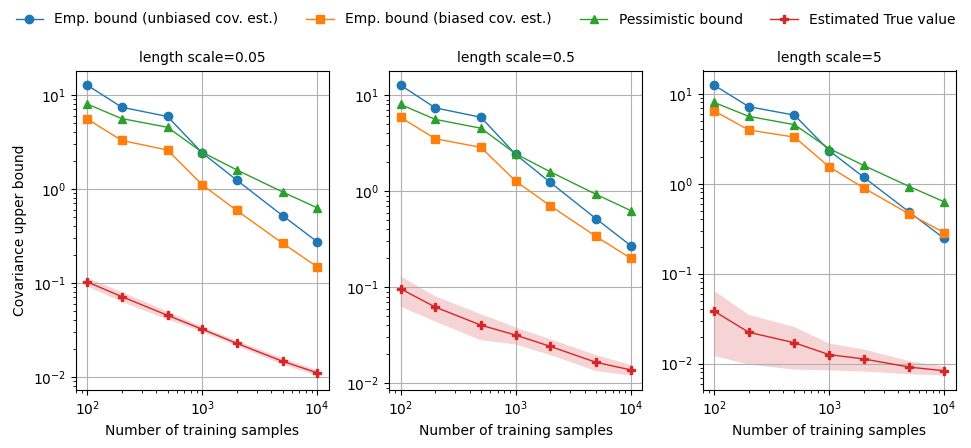

In [59]:
delta = 0.05
Ns = [100,200,500,1000,2000,5000,10000]#,20000,40000]
length_scales = [0.05, 0.5, 5]
pess_bounds = []
data_bounds_biased = []
data_bounds_unbiased = []
true_values = []
for l in length_scales:
    pess_bounds.append(np.load(f'pess_bound_delta_{delta}_l_{l}.npy'))
    data_bounds_biased.append(np.load(f'data_bound_biased_cov_est_delta_{delta}_l_{l}.npy'))
    data_bounds_unbiased.append(np.load(f'data_bound_unbiased_cov_est_delta_{delta}_l_{l}.npy'))
    true_values.append(np.load(f'True_value_delta_{delta}_l_{l}.npy'))

# Create a figure with 3 subplots in a row, single-column width (3.25 inches)
fig, axes = plt.subplots(1, 3, figsize=(3.25 * 3, 4.5))  # Adjust height as needed for visibility

# Plot each subplot and collect lines for the legend
lines = []
for i, length_scale in enumerate(length_scales):
    show_ylabel = (i == 0)  # Only show y-axis label on the first subplot
    lines += plot_OU2(axes[i], pess_bounds[i], data_bounds_biased[i], data_bounds_unbiased[i], true_values[i], Ns, delta, length_scale, show_ylabel=show_ylabel)

# Create a common legend
labels = ["Emp. bound (unbiased cov. est.)", "Emp. bound (biased cov. est.)", "Pessimistic bound", "Estimated True value"]
fig.legend(lines[:4], labels, loc='upper center', fontsize=10, ncol=4, frameon=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.subplots_adjust(top=0.85)  # Add more space between title and legend
plt.savefig("OU_Exp_different_length_scales_NeurIPS.pdf", format="pdf", dpi=900)
plt.show()